In [6]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [7]:
# target은 Churn
data = pd.read_csv('./data/train.csv')

#### 결측치 처리

## EDA

In [33]:
data.isna().sum()

CustomerID                     0
Churn                          0
MonthlyRevenue               156
MonthlyMinutes               156
TotalRecurringCharge         156
DirectorAssistedCalls        156
OverageMinutes               156
RoamingCalls                 156
PercChangeMinutes            367
PercChangeRevenues           367
DroppedCalls                   0
BlockedCalls                   0
UnansweredCalls                0
CustomerCareCalls              0
ThreewayCalls                  0
ReceivedCalls                  0
OutboundCalls                  0
InboundCalls                   0
PeakCallsInOut                 0
OffPeakCallsInOut              0
DroppedBlockedCalls            0
CallForwardingCalls            0
CallWaitingCalls               0
MonthsInService                0
UniqueSubs                     0
ActiveSubs                     0
ServiceArea                   24
Handsets                       1
HandsetModels                  1
CurrentEquipmentDays           1
AgeHH1    

In [8]:
print(f'data count: {len(data)}')
print(f'nan Max count: {data.isna().sum().max()}')
print(f'duplicated count: {data.duplicated().sum()}')
# # NA의 개수가 데이터 전체 개수에 비해 적으므로 제거하고 사용
data = data.dropna()
# CustomerID는 학습과 관련이 없어 삭제하고 진행
data = data.drop(columns='CustomerID')

data count: 51047
nan Max count: 909
duplicated count: 0


#### EDA

In [36]:
#타겟 시각화
data.Churn.value_counts()

Churn
No     36336
Yes    14711
Name: count, dtype: int64

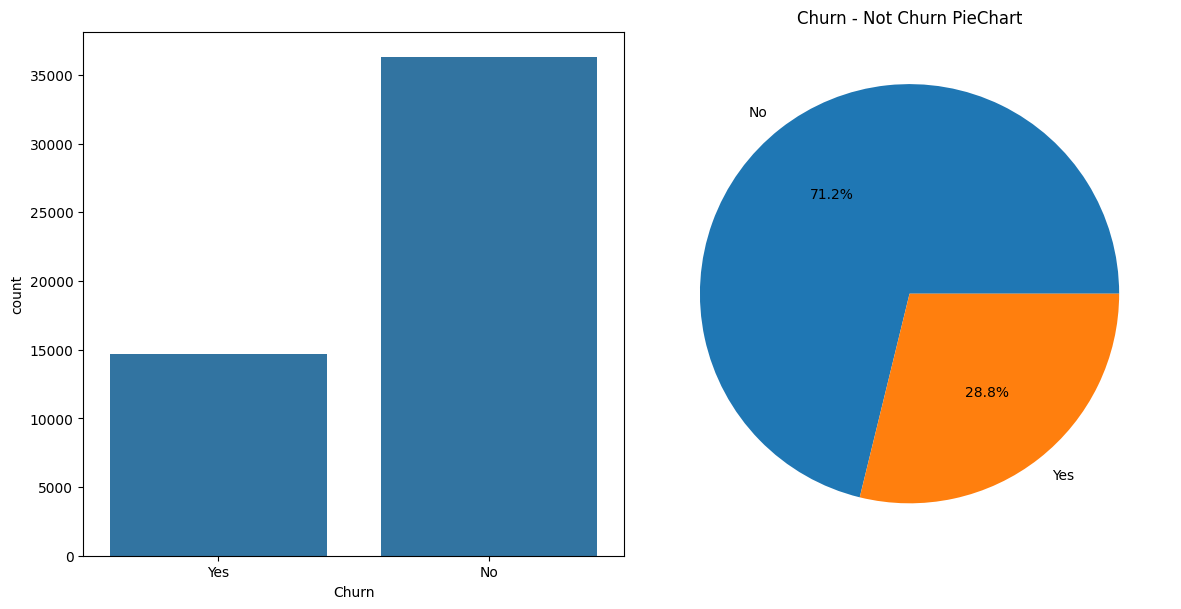

In [37]:
plt.subplots(1, 2, figsize=(12,6))
plt.subplot(1, 2, 1)
sns.countplot(
    data,
    x='Churn'
)
plt.subplot(1, 2, 2)
plt.pie(
    data.Churn.value_counts(),
    labels=data.Churn.value_counts().index,
    autopct='%1.1f%%',
)
plt.title('Churn - Not Churn PieChart')
plt.tight_layout()
plt.show()

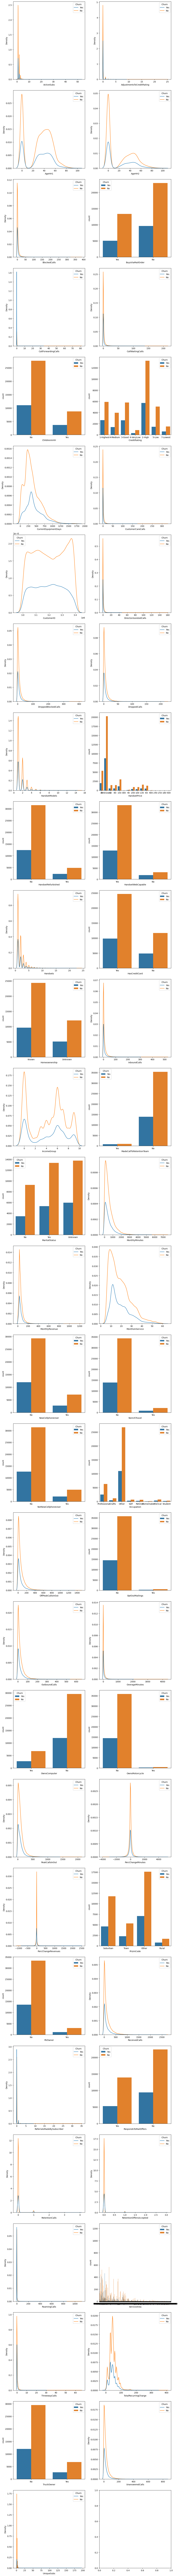

In [51]:
# 각 피쳐별 Churn에 따른 시각화
size = len(data.columns.difference(['Churn']))
plt.subplots(size//2 + size%2, 2, figsize=(12, 6*size//2))
for i, col in enumerate(data.columns.difference(['Churn'])):
    plt.subplot(size//2 + size%2, 2, i + 1)
    if data[col].dtype == object:
        sns.countplot(
            data,
            x=col,
            hue='Churn'
        )
    else:
        sns.kdeplot(
            data,
            x=col,
            hue='Churn'
        )
plt.tight_layout()
plt.show()

전체적인 Churn에대한 coutPlot과 kdePlot을 보았을때 개별 Feature에 대한 Churn의 Yes의 개수가 No보다 많은것도 없고,<br>비율도 같은비율만 있어 현재 데이터로는 Churn의 YES와 NO를 구분할 방법이 없는것으로 판단하였습니다.<br>


#### Feature Creation

##### **연속형 데이터를 범주형 데이터로 만들기**

In [ ]:
data['TotalRecurringCharge_label'] = pd.cut(data.TotalRecurringCharge, 8, labels=range(8))
data['MonthsInService_label'] = pd.cut(data.MonthsInService, 6, labels=range(6))
data['AgeHH1_label'] = pd.cut(data.AgeHH1, 5, labels=range(5))
data['AgeHH2_label'] = pd.cut(data.AgeHH2, 5, labels=range(5))
data['MonthlyMinutes_label'] = pd.qcut(data.MonthlyMinutes, 10, labels=range(10))
data['MonthlyRevenue_label'] = pd.cut(data.MonthlyRevenue, 8, labels=range(8))

<Figure size 640x480 with 0 Axes>

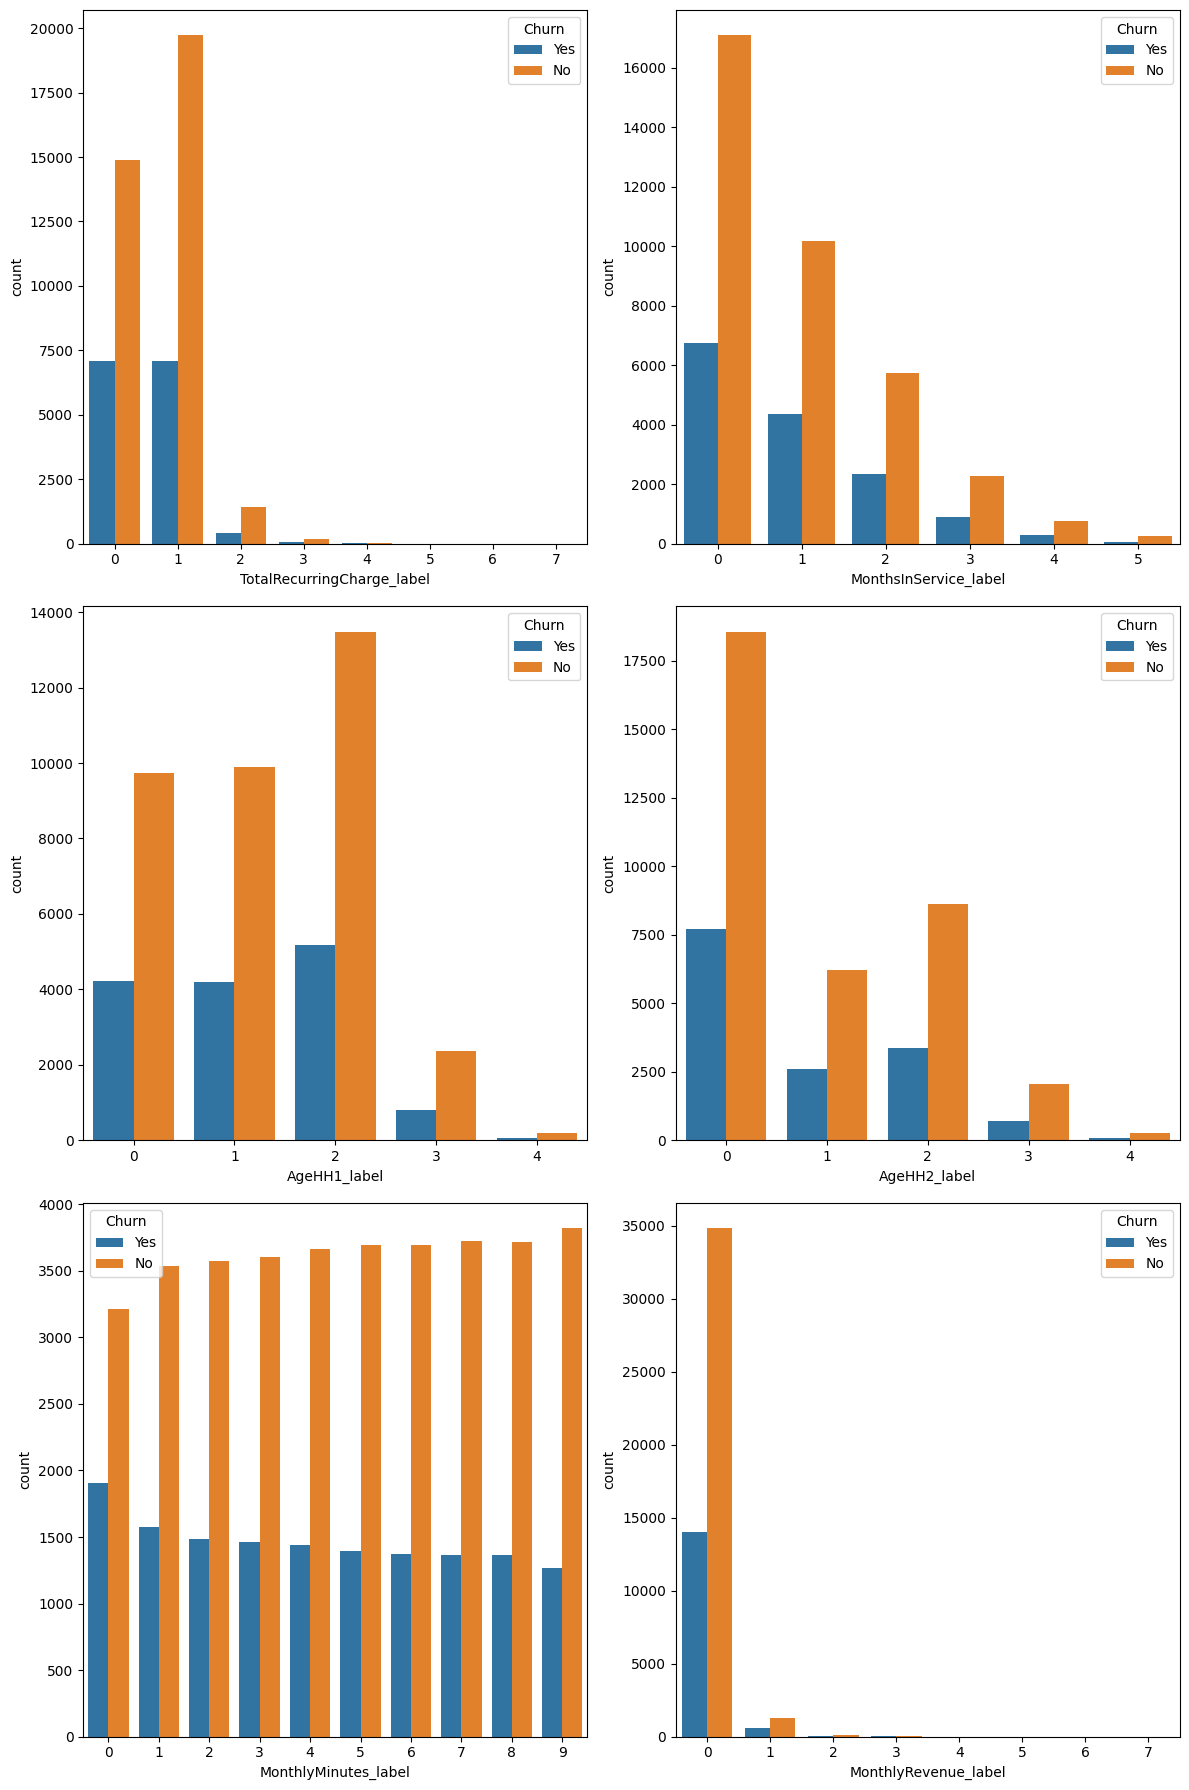

In [ ]:
plt.clf()
size = len(data.columns[data.columns.str.contains('_label')])
plt.subplots(size//2 + size%2, 2, figsize=(12, 6*size//2))
for i, col in enumerate(data.columns[data.columns.str.contains('_label')]):
    plt.subplot(size//2 + size%2, 2, i + 1)
    sns.countplot(
        data,
        x=col,
        hue='Churn'
    )
plt.tight_layout()
plt.show()

##### **클러스터링을 통한 새로운 라벨 만들기**

In [9]:
def convert_object_into_integer(df: pd.DataFrame):
    label_encoders = {}
    for column in df.columns:
        if df.dtypes[column] == object:
            label_encoder = LabelEncoder()
            df[column] = label_encoder.fit_transform(df[column])
            label_encoders.update({column: label_encoder})
    
    return df, label_encoders

In [10]:
data, _ = convert_object_into_integer(data)

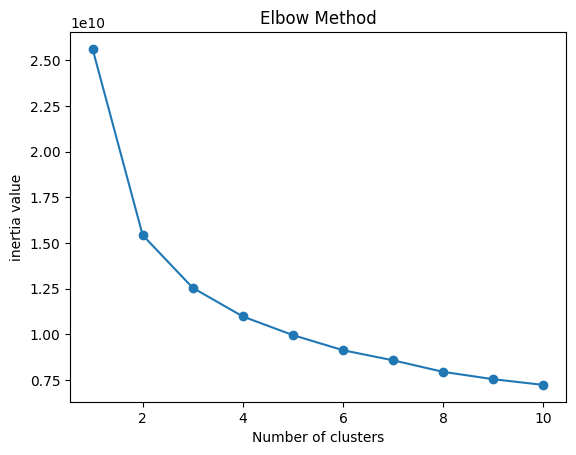

In [11]:
inertias = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(data.drop(columns=['Churn']))
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 11), inertias, '-o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('inertia value')
plt.show()


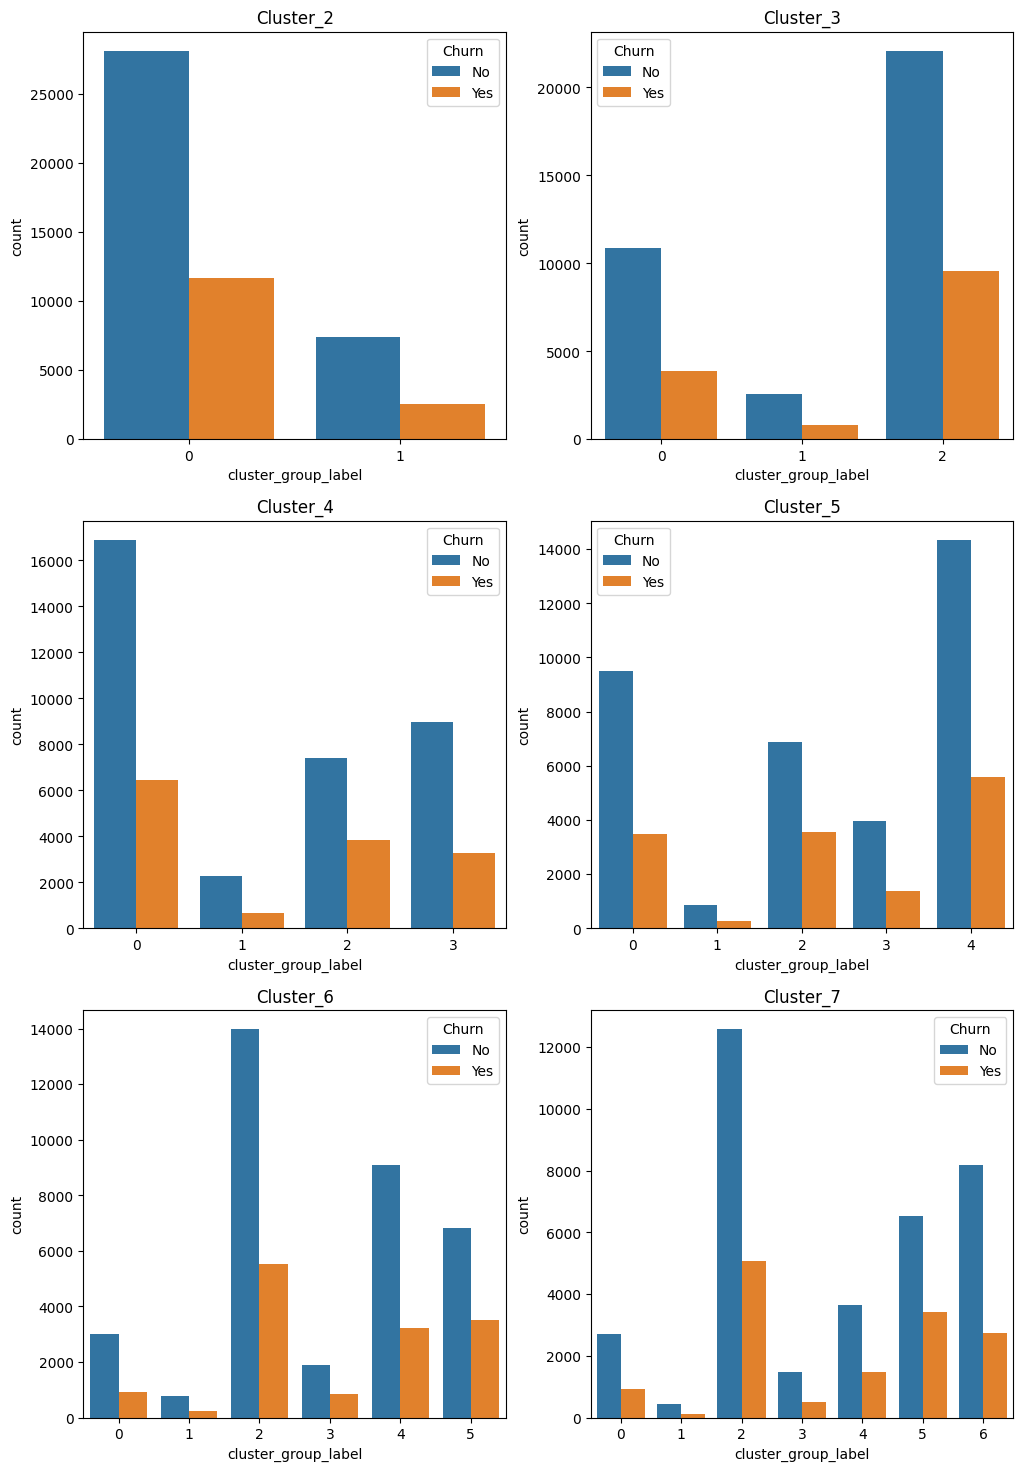

In [ ]:
plt.subplots(3, 2, figsize=(12, 18))
for i in range(2, 8):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(data.drop(columns=['Churn']))
    data['cluster_group_label'] = kmeans.labels_
    plt.subplot(3, 2, i-1)
    sns.countplot(
        data,
        x='cluster_group_label',
        hue='Churn',
    )
    plt.legend(title='Churn', labels=['No', 'Yes'])
    plt.title(f'Cluster_{i}')
plt.show()

##### 2가지 방법으로 새로운 Feature를 작성 해보았지만 EDA상 유의미한 정보를 찾지 못하였습니다.

#### Type 변경

In [ ]:
def convert_object_into_integer(df: pd.DataFrame):
    label_encoders = {}
    for column in df.columns:
        if df.dtypes[column] == object:
            label_encoder = LabelEncoder()
            df[column] = label_encoder.fit_transform(df[column])
            label_encoders.update({column: label_encoder})
    
    return df, label_encoders

In [ ]:
data, _ = convert_object_into_integer(data)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49752 entries, 0 to 51043
Data columns (total 57 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Churn                      49752 non-null  int32  
 1   MonthlyRevenue             49752 non-null  float64
 2   MonthlyMinutes             49752 non-null  float64
 3   TotalRecurringCharge       49752 non-null  float64
 4   DirectorAssistedCalls      49752 non-null  float64
 5   OverageMinutes             49752 non-null  float64
 6   RoamingCalls               49752 non-null  float64
 7   PercChangeMinutes          49752 non-null  float64
 8   PercChangeRevenues         49752 non-null  float64
 9   DroppedCalls               49752 non-null  float64
 10  BlockedCalls               49752 non-null  float64
 11  UnansweredCalls            49752 non-null  float64
 12  CustomerCareCalls          49752 non-null  float64
 13  ThreewayCalls              49752 non-null  float64


In [26]:
corr = data.corr(numeric_only=True)

In [27]:
px.imshow(corr, 
                text_auto=True,  
                aspect="auto"
               )

Heatmap을 통한 결과에서 Churn과 다른Feature들간에 유의미한 상관관계는 보이지 않는것으로 판단됩니다.

In [70]:
data.Churn.value_counts() / data.Churn.value_counts().sum() 

Churn
No     0.711815
Yes    0.288185
Name: count, dtype: float64

#### 결론


Churn과 Feature간의 유의미한 관계가 있는 데이터가 없다고 보여지기 때문에 기본적으로 모델을 돌렸을때의 예상Score는
둘의 비율인 0.71에 근접하는 결과가 나올것 같습니다.<br> 
타겟의 데이터가 분균일하기 때문에 accuracy 보다는 **precision 과 recall**의 결과에 대해서 더 잘봐야 할 것 같습니다.<br>